In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mido import MidiFile, tick2second
from pretty_midi import PrettyMIDI
import pickle

import subprocess
import os
import os.path
import random
from ExtractBootlegFeatures import *
import multiprocessing

### Generating bootleg score

In [3]:
def showImage(X, sz = (6,6)):
    plt.figure(figsize = sz)
    plt.imshow(X, cmap = 'gray', origin = 'lower')

In [4]:
def getNoteEvents(midifile, quant = 10):
    ### Given a midi file, return a list of (t_tick, t_sec, notes) tuples for simultaneous note events
    
    # get note onset info
    mid = MidiFile(midifile)
    noteEvents = []
    checkForDuplicates = {}
    for i, track in enumerate(mid.tracks):
        t = 0 
        for msg in track:
            t += msg.time # ticks since last event
            if msg.type == 'note_on' and msg.velocity > 0:
                key = '{},{}'.format(t,msg.note)
                if key not in checkForDuplicates:
                    noteEvents.append((t, msg.note))
                    checkForDuplicates[key] = 0
    noteEvents = sorted(noteEvents) # merge note events from all tracks, sort by time
    pm = PrettyMIDI(midifile)
    noteOnsets = [(t_ticks, pm.tick_to_time(t_ticks), note) for (t_ticks, note) in noteEvents]
    
    # collapse simultaneous notes
    d = {}
    ticks_quant = [n[0]//quant for n in noteOnsets] # quantized time units (ticks)
    for n, t_quant in zip(noteOnsets, ticks_quant):
        if t_quant not in d:
            d[t_quant] = {}
            d[t_quant]['ticks'] = []
            d[t_quant]['secs'] = []
            d[t_quant]['notes'] = []
        d[t_quant]['ticks'].append(n[0])
        d[t_quant]['secs'].append(n[1])
        d[t_quant]['notes'].append(n[2])
        
    result = [(d[key]['ticks'][0], d[key]['secs'][0], d[key]['notes']) for key in sorted(d.keys())]
    
    return result, d # return d for debugging

In [5]:
def generateBootlegScore(noteEvents, repeatNotes = 1, filler = 1):
    rh_dim = 34 # E3 to C8 (inclusive)
    lh_dim = 28 # A1 to G4 (inclusive)
    rh = [] # list of arrays of size rh_dim
    lh = [] # list of arrays of size lh_dim
    numNotes = [] # number of simultaneous notes
    times = [] # list of (tsec, ttick) tuples indicating the time in ticks and seconds
    mapR, mapL = getNoteheadPlacementMapping() # maps midi numbers to locations on right and left hand staves
    for i, (ttick, tsec, notes) in enumerate(noteEvents):
        
        # insert empty filler columns between note events
        if i > 0:
            for j in range(filler):
                rh.append(np.zeros((rh_dim,1)))
                lh.append(np.zeros((lh_dim,1)))
                numNotes.append(0)
            # get corresponding times using linear interpolation
            interp_ticks = np.interp(np.arange(1, filler+1), [0, filler+1], [noteEvents[i-1][0], ttick])
            interp_secs = np.interp(np.arange(1, filler+1), [0, filler+1], [noteEvents[i-1][1], tsec])
            for tup in zip(interp_secs, interp_ticks):
                times.append((tup[0], tup[1]))

        # insert note events columns
        rhvec = np.zeros((rh_dim, 1))
        lhvec = np.zeros((lh_dim, 1))
        for midinum in notes:
            rhvec += getNoteheadPlacement(midinum, mapR, rh_dim)
            lhvec += getNoteheadPlacement(midinum, mapL, lh_dim)
        for j in range(repeatNotes):
            rh.append(rhvec)
            lh.append(lhvec)
            numNotes.append(len(notes))
            times.append((tsec, ttick))
    rh = np.clip(np.squeeze(np.array(rh)).T, 0, 1) # clip in case e.g. E and F played simultaneously
    lh = np.clip(np.squeeze(np.array(lh)).T, 0, 1) 
    both = np.vstack((lh, rh))
    staffLinesRH = [7,9,11,13,15]
    staffLinesLH = [13,15,17,19,21]
    staffLinesBoth = [13,15,17,19,21,35,37,39,41,43]
    return both, times, numNotes, staffLinesBoth, (rh, staffLinesRH), (lh, staffLinesLH)

In [6]:
def getNoteheadPlacementMapping():
    r = getNoteheadPlacementMappingRH()
    l = getNoteheadPlacementMappingLH()
    #r, l = addOctaveChanges(r, l) # uncomment to include octave markings
    #r, l = addClefChanges(r, l) # uncomment to include different clefs
    return r, l

In [7]:
def getNoteheadPlacementMappingLH():
    d = {}
    # e.g. d[23] = [1,2] indicates that B0 could appear as a B or a C-flat, which means
    # that the notehead could be located at positions 1 or 2
    d[21] = [0] # A0 (position 0)
    d[22] = [0,1]
    d[23] = [1,2] # B0
    d[24] = [1,2] # C1
    d[25] = [2,3]
    d[26] = [3] # D1
    d[27] = [3,4]
    d[28] = [4,5] # E1
    d[29] = [4,5] # F1
    d[30] = [5,6]
    d[31] = [6] # G1
    d[32] = [6,7] 
    d[33] = [7] # A1
    d[34] = [7,8]
    d[35] = [8,9] # B1
    d[36] = [8,9] # C2
    d[37] = [9,10] 
    d[38] = [10] # D2
    d[39] = [10,11] 
    d[40] = [11,12] # E2
    d[41] = [11,12] # F2
    d[42] = [12,13] 
    d[43] = [13] # G2
    d[44] = [13,14] 
    d[45] = [14] # A2
    d[46] = [14,15] 
    d[47] = [15,16] # B2
    d[48] = [15,16] # C3
    d[49] = [16,17] 
    d[50] = [17] # D3
    d[51] = [17,18] 
    d[52] = [18,19] # E3
    d[53] = [18,19] # F3
    d[54] = [19,20] 
    d[55] = [20] # G3
    d[56] = [20,21] 
    d[57] = [21] # A3
    d[58] = [21,22] 
    d[59] = [22,23] # B3
    d[60] = [22,23] # C4
    d[61] = [23,24] 
    d[62] = [24] # D4
    d[63] = [24,25] 
    d[64] = [25,26] # E4
    d[65] = [25,26] # F4
    d[66] = [26,27] 
    d[67] = [27] # G4
    return d

In [8]:
def getNoteheadPlacementMappingRH():
    d = {}
    # e.g. d[52] = [0,1] indicates that E3 could appear as an E or an F-flat, which means
    # that the notehead could be located at positions 0 or 1
    d[52] = [0,1] # E3 (position 0)
    d[53] = [0,1] # F3
    d[54] = [1,2]
    d[55] = [2] # G3
    d[56] = [2,3]
    d[57] = [3] # A3
    d[58] = [3,4]
    d[59] = [4,5] # B3
    d[60] = [4,5] # C4
    d[61] = [5,6]
    d[62] = [6] # D4
    d[63] = [6,7]
    d[64] = [7,8] # E4
    d[65] = [7,8] # F4
    d[66] = [8,9]
    d[67] = [9] # G4
    d[68] = [9,10]
    d[69] = [10] # A4
    d[70] = [10,11]
    d[71] = [11,12] # B4
    d[72] = [11,12] # C5
    d[73] = [12,13]
    d[74] = [13] # D5
    d[75] = [13,14]
    d[76] = [14,15] # E5
    d[77] = [14,15] # F5
    d[78] = [15,16]
    d[79] = [16] # G5
    d[80] = [16,17]
    d[81] = [17] # A5
    d[82] = [17,18] 
    d[83] = [18,19] # B5
    d[84] = [18,19] # C6
    d[85] = [19,20]
    d[86] = [20] # D6
    d[87] = [20,21]
    d[88] = [21,22] # E6
    d[89] = [21,22] # F6
    d[90] = [22,23]
    d[91] = [23] # G6
    d[92] = [23,24] 
    d[93] = [24] # A6
    d[94] = [24,25]
    d[95] = [25,26] # B6
    d[96] = [25,26] # C7
    d[97] = [26,27]
    d[98] = [27] # D7
    d[99] = [27,28] 
    d[100] = [28,29] # E7
    d[101] = [28,29] # F7
    d[102] = [29,30]
    d[103] = [30] # G7
    d[104] = [30,31]    
    d[105] = [31] # A7
    d[106] = [31,32]
    d[107] = [32,33] # B7
    d[108] = [32,33] # C8
    return d

In [9]:
def addOctaveChanges(r, l):
    
    # add octaves in treble clef for G5 and above
    for midinum in r:
        if midinum >= 79:
            toAdd = []
            for staffpos in r[midinum]:
                toAdd.append(staffpos - 7) # 7 staff positions = 1 octave
            r[midinum].extend(toAdd)
    
    # add octaves in bass clef for F2 and below
    for midinum in l:
        if midinum <= 41:
            toAdd = []
            for staffpos in l[midinum]:
                toAdd.append(staffpos + 7)
            l[midinum].extend(toAdd)
    
    return r, l

In [10]:
def addClefChanges(r, l):
    
    # clef change in rh
    for midinum in range(36, 65):  # C2 to E4
        if midinum not in r:
            r[midinum] = []
        for staffpos in l[midinum]:
            r[midinum].append(staffpos - 6) # shift between L and R staves (e.g. middle staff line is pos 11 in rh, pos 17 in lh)
            
    # clef change in lh
    for midinum in range(57, 85): # A3 to C6
        if midinum not in l:
            l[midinum] = []
        for staffpos in r[midinum]:
            l[midinum].append(staffpos + 6)
            
    return r, l

In [11]:
def getNoteheadPlacement(midinum, midi2loc, dim):
    r = np.zeros((dim, 1))
    if midinum in midi2loc:
        for idx in midi2loc[midinum]:
            r[idx,0] = 1
    return r

In [12]:
def visualizeBootlegScore(bs, lines):
    showImage(1 - bs, (10,10))
    for l in range(1, bs.shape[0], 2):
        plt.axhline(l, c = 'b')
    for l in lines:
        plt.axhline(l, c = 'r')

In [13]:
midifile = 'data/midi/p91.mid'

/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


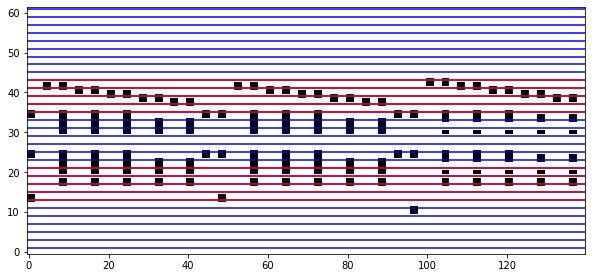

In [14]:
note_events, _ = getNoteEvents(midifile)
bscore, times, num_notes, stafflines, _, _ = generateBootlegScore(note_events, 2, 2)
visualizeBootlegScore(bscore[:,0:140], stafflines)

### Process midi files

In [15]:
def processMidiFile(midifile, outfile):
    
    ### system parameters ###
    timeQuantFactor = 10
    bootlegRepeatNotes = 2
    bootlegFiller = 1
    #########################
    
    print("Processing {}".format(midifile))
    note_events, _ = getNoteEvents(midifile, timeQuantFactor)
    bscore, times, num_notes, stafflines, _, _ = generateBootlegScore(note_events, bootlegRepeatNotes, bootlegFiller)
    
    # save to file
    d = {'bscore': bscore, 'times': times, 'num_notes': num_notes, 'stafflines': stafflines, 'note_events': note_events}
    with open(outfile, 'wb') as f:
        pickle.dump(d, f)

In [16]:
def processAllMidiFiles(filelist, outdir):
    if not os.path.isdir(outdir):
        os.makedirs(outdir)
    with open(filelist, 'r') as f:
        for curfile in f:
            curfile = curfile.rstrip()
            basename = os.path.splitext(os.path.basename(curfile))[0]
            outfile = "{}/{}.pkl".format(outdir, basename)
            processMidiFile(curfile, outfile)

In [17]:
filelist = 'cfg_files/midi.test.list' # list of all midi files to process
basedir = 'experiments/test'
outdir = '{}/db'.format(basedir) # where to save bootleg scores
processAllMidiFiles(filelist, outdir)

Processing data/midi/p2.mid
Processing data/midi/p3.mid
Processing data/midi/p4.mid
Processing data/midi/p6.mid
Processing data/midi/p7.mid
Processing data/midi/p8.mid
Processing data/midi/p9.mid
Processing data/midi/p10.mid
Processing data/midi/p12.mid
Processing data/midi/p13.mid
Processing data/midi/p14.mid
Processing data/midi/p16.mid
Processing data/midi/p17.mid
Processing data/midi/p18.mid
Processing data/midi/p19.mid
Processing data/midi/p20.mid
Processing data/midi/p22.mid
Processing data/midi/p23.mid
Processing data/midi/p24.mid
Processing data/midi/p26.mid
Processing data/midi/p27.mid
Processing data/midi/p28.mid
Processing data/midi/p29.mid
Processing data/midi/p30.mid
Processing data/midi/p32.mid
Processing data/midi/p33.mid
Processing data/midi/p34.mid
Processing data/midi/p36.mid
Processing data/midi/p37.mid
Processing data/midi/p38.mid
Processing data/midi/p39.mid
Processing data/midi/p40.mid
Processing data/midi/p42.mid
Processing data/midi/p43.mid
Processing data/midi/

### Convert PDFs to JPGs

In [18]:
path = ""
for i in range(1,5001):
    print("Processing p"+str(i))
    if os.path.exists('/data1/dyang/imslp_dataset/pdfs/p'+str(i)+'.pdf'):
        if not os.path.exists('/data1/dyang/imslp_dataset/images/p'+str(i)+'/'):
            subprocess.call('mkdir /data1/dyang/imslp_dataset/images/p'+str(i),shell=True)
            subprocess.call('convert -density 500 /data1/dyang/imslp_dataset/pdfs/p'+str(i)+'.pdf -quality 100 /data1/dyang/imslp_dataset/images/p'+str(i)+'/p'+str(i)+'.jpg', shell=True)
    else:
        print("Skipped p"+str(i))


Processing p1
Skipped p1
Processing p2
Skipped p2
Processing p3
Skipped p3
Processing p4
Skipped p4
Processing p5
Skipped p5
Processing p6
Skipped p6
Processing p7
Skipped p7
Processing p8
Skipped p8
Processing p9
Skipped p9
Processing p10
Skipped p10
Processing p11
Skipped p11
Processing p12
Skipped p12
Processing p13
Skipped p13
Processing p14
Skipped p14
Processing p15
Skipped p15
Processing p16
Skipped p16
Processing p17
Skipped p17
Processing p18
Skipped p18
Processing p19
Skipped p19
Processing p20
Skipped p20
Processing p21
Skipped p21
Processing p22
Skipped p22
Processing p23
Skipped p23
Processing p24
Skipped p24
Processing p25
Skipped p25
Processing p26
Skipped p26
Processing p27
Skipped p27
Processing p28
Skipped p28
Processing p29
Skipped p29
Processing p30
Skipped p30
Processing p31
Skipped p31
Processing p32
Skipped p32
Processing p33
Skipped p33
Processing p34
Skipped p34
Processing p35
Skipped p35
Processing p36
Skipped p36
Processing p37
Skipped p37
Processing p38
Skip

Skipped p908
Processing p909
Skipped p909
Processing p910
Skipped p910
Processing p911
Skipped p911
Processing p912
Skipped p912
Processing p913
Skipped p913
Processing p914
Skipped p914
Processing p915
Skipped p915
Processing p916
Skipped p916
Processing p917
Skipped p917
Processing p918
Skipped p918
Processing p919
Skipped p919
Processing p920
Skipped p920
Processing p921
Skipped p921
Processing p922
Skipped p922
Processing p923
Skipped p923
Processing p924
Skipped p924
Processing p925
Skipped p925
Processing p926
Skipped p926
Processing p927
Skipped p927
Processing p928
Skipped p928
Processing p929
Skipped p929
Processing p930
Skipped p930
Processing p931
Skipped p931
Processing p932
Skipped p932
Processing p933
Skipped p933
Processing p934
Skipped p934
Processing p935
Skipped p935
Processing p936
Skipped p936
Processing p937
Skipped p937
Processing p938
Skipped p938
Processing p939
Skipped p939
Processing p940
Skipped p940
Processing p941
Skipped p941
Processing p942
Skipped p942
P

Processing p2089
Skipped p2089
Processing p2090
Skipped p2090
Processing p2091
Skipped p2091
Processing p2092
Skipped p2092
Processing p2093
Skipped p2093
Processing p2094
Skipped p2094
Processing p2095
Skipped p2095
Processing p2096
Skipped p2096
Processing p2097
Skipped p2097
Processing p2098
Skipped p2098
Processing p2099
Skipped p2099
Processing p2100
Skipped p2100
Processing p2101
Skipped p2101
Processing p2102
Skipped p2102
Processing p2103
Skipped p2103
Processing p2104
Skipped p2104
Processing p2105
Skipped p2105
Processing p2106
Skipped p2106
Processing p2107
Skipped p2107
Processing p2108
Skipped p2108
Processing p2109
Skipped p2109
Processing p2110
Skipped p2110
Processing p2111
Skipped p2111
Processing p2112
Skipped p2112
Processing p2113
Skipped p2113
Processing p2114
Skipped p2114
Processing p2115
Skipped p2115
Processing p2116
Skipped p2116
Processing p2117
Skipped p2117
Processing p2118
Skipped p2118
Processing p2119
Skipped p2119
Processing p2120
Skipped p2120
Processi

Processing p3589
Skipped p3589
Processing p3590
Skipped p3590
Processing p3591
Skipped p3591
Processing p3592
Skipped p3592
Processing p3593
Skipped p3593
Processing p3594
Skipped p3594
Processing p3595
Skipped p3595
Processing p3596
Skipped p3596
Processing p3597
Skipped p3597
Processing p3598
Skipped p3598
Processing p3599
Skipped p3599
Processing p3600
Skipped p3600
Processing p3601
Skipped p3601
Processing p3602
Skipped p3602
Processing p3603
Skipped p3603
Processing p3604
Skipped p3604
Processing p3605
Skipped p3605
Processing p3606
Skipped p3606
Processing p3607
Skipped p3607
Processing p3608
Skipped p3608
Processing p3609
Skipped p3609
Processing p3610
Skipped p3610
Processing p3611
Skipped p3611
Processing p3612
Skipped p3612
Processing p3613
Skipped p3613
Processing p3614
Skipped p3614
Processing p3615
Skipped p3615
Processing p3616
Skipped p3616
Processing p3617
Skipped p3617
Processing p3618
Skipped p3618
Processing p3619
Skipped p3619
Processing p3620
Skipped p3620
Processi

Skipped p4997
Processing p4998
Skipped p4998
Processing p4999
Skipped p4999
Processing p5000
Skipped p5000


### Extract Bootleg Features from Images

In [19]:
def convert_Pdf_wrapper(i):
    basedir = 'experiments/allBootlegScores-c/'
    outdir = '{}/scores/'.format(basedir)
    imagedir = '/data1/dyang/imslp_dataset/dataset-a/images/'
    numPdfs=5024;
    if i >= numPdfs:
        return
    if not os.path.isdir(outdir):
        os.makedirs(outdir)
    
    outfile = outdir + 'p{}.pkl'.format(str(i))
    if i <= 200:
        filepath = imagedir + 'p'+str(i)+'a/'
    else:
        filepath = imagedir + 'p'+str(i)+'/'
    if os.path.exists(outfile):
        print(str(i)+" is already there")
        return
    total_bscore = np.zeros((62,1))
    lst = len(os.listdir(filepath))
    if lst == 1:
        if i<=200:
            imagepath = filepath+'p{}a.jpg'.format(i)
        else:
            imagepath = filepath+'p{}.jpg'.format(i)
        try:
            bscore_query = processQuery(imagepath)
        except:
            bscore_query = np.zeros((62,1))
        total_bscore = np.concatenate((total_bscore, bscore_query),axis=1)
    else:
        for count in range(lst):
            try:
                if i<=200:
                    imagepath = filepath+'p{}a-{}.jpg'.format(i,count)
                else:
                    imagepath = filepath+'p{}-{}.jpg'.format(i,count)
                bscore_query=processQuery(imagepath)
            except:
                bscore_query = np.zeros((62,1))
            total_bscore = np.concatenate((total_bscore, bscore_query),axis=1)
    with open(outfile, 'wb') as f:
        print("Saving p" + str(i))
        pickle.dump(total_bscore, f)
    print(total_bscore.shape)
        #visualizeLongBootlegScore(total_bscore, [13,15,17,19,21,35,37,39,41,43])

In [20]:
convert_Pdf_wrapper(1234)

1234 is already there


In [27]:
inputs = [[201+i] for i in range(0,5001)]
n_cores = 28

pool = multiprocessing.Pool(processes=n_cores)
outputs = list(pool.starmap(convert_Pdf_wrapper, inputs))

246 is already there
201 is already there
202 is already there
471 is already there
291 is already there
203 is already there
426 is already there
921 is already there
336 is already there
966 is already there
381 is already there
204 is already there
1011 is already there
292 is already there
247 is already there
1146 is already there
876 is already there
1101 is already there
516 is already there
1191 is already there
786 is already there
741 is already there
472 is already there
427 is already there
831 is already there
922 is already there
337 is already there
205 is already there
967 is already there
382 is already there
1012 is already there
1236 is already there
1281 is already there
248 is already there
517 is already there
1192 is already there
1102 is already there
877 is already there
293 is already there
787 is already there
742 is already there
1416 is already there
473 is already there
1056 is already there
1371 is already there
832 is already there
1147 is already there


705 is already there
1027 is already there
308 is already there
1341 is already there
757 is already there
938 is already there
802 is already there
1162 is already there
533 is already there
1252 is already there
1208 is already there
353 is already there
443 is already there
615 is already there
264 is already there
660 is already there
893 is already there
1072 is already there
983 is already there
1118 is already there
1028 is already there
1342 is already there
706 is already there
309 is already there
758 is already there
803 is already there
1163 is already there
534 is already there
1253 is already there
1209 is already there
354 is already there
444 is already there
616 is already there
265 is already there
661 is already there
894 is already there
1073 is already there
984 is already there
1119 is already there
1029 is already there
1343 is already there
707 is already there
310 is already there
759 is already there
804 is already there
1164 is already there
535 is already th

1189 is already there
784 is already there
642 is already there
1098 is already there
1145 is already there
687 is already there
380 is already there
1279 is already there
560 is already there
1190 is already there
785 is already there
643 is already there
1099 is already there
1280 is already there
1461 is already there
688 is already there
1506 is already there
1100 is already there
1462 is already there
1596 is already there
1686 is already there
1551 is already there
689 is already there
1507 is already there
1463 is already there
1597 is already there
1687 is already there
1731 is already there
690 is already there
1552 is already there
1508 is already there
1464 is already there
1598 is already there
1688 is already there
1732 is already there
1509 is already there
1553 is already there
691 is already there
1465 is already there
1599 is already there
1689 is already there
1733 is already there
1510 is already there
1554 is already there
692 is already there
1466 is already there


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (147151184 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p906/p906-0.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1349/p1349-0.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1227/p1227-0.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1047/p1047-0.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p286/p286-0.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p463/p463-0.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p693/p693-0.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p644/p644-0.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p331/p331-0.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1601/p1601-0.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1641/p1641-0.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1478/p1478-0.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1761/p1761-0.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1521/p1

/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (132806232 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p1601/p1601-1.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1047/p1047-1.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1641/p1641-1.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p484/p484-1.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p987/p987-1.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p839/p839-1.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p567/p567-1.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1349/p1349-1.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1047/p1047-2.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p392/p392-1.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1521/p1521-1.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p693/p693-1.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p906/p906-1.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1378/p137

/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (159798028 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p1721/p1721-3.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p484/p484-5.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1047/p1047-6.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p839/p839-4.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1521/p1521-4.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1761/p1761-3.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p463/p463-4.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p906/p906-4.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p567/p567-5.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p286/p286-3.jpg
Saving p1378
(62, 2124)
1379 is already there
Saving p392
1380 is already there
1381 is already there
(62, 1803)
1382 is already there
1383 is already there
393 is already there
1384 is already there
1385 is already there
1386 is already there
394 is already there
1387 is already t

/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (143443976 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p416/p416-1.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1839/p1839-1.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p839/p839-5.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p286/p286-4.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1761/p1761-4.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p906/p906-5.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p644/p644-5.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1921/p1921-1.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1721/p1721-4.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p939/p939-5.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1349/p1349-5.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1295/p1295-5.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1047/p1047-8.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p710/p71

/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (165648000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


1453 is already there
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1454/p1454-0.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1227/p1227-7.jpg
Saving p1295
(62, 2019)
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1349/p1349-7.jpg
1296 is already there
1297 is already there
1298 is already there
1299 is already there
Saving p939
1300 is already there
1301 is already there
(62, 1986)
1302 is already there
1303 is already there
940 is already there
941 is already there
942 is already there
943 is already there
944 is already there
945 is already there
946 is already there
1304 is already there
947 is already there
1305 is already there
1306 is already there
948 is already there
1307 is already there
949 is already there
1308 is already there
1309 is already there
950 is already there
1310 is already there
951 is already there
1311 is already there
952 is already there
953 is already there
954 is already there
955 is already there
956 is already there
957

Saving p1478
(62, 4778)
1479 is already there
1480 is already there
1481 is already there
1482 is already there
1483 is already there
1484 is already there
1485 is already there
1486 is already there
1487 is already there
1488 is already there
1489 is already there
1490 is already there
1491 is already there
1492 is already there
1493 is already there
1494 is already there
1495 is already there
1496 is already there
1497 is already there
1498 is already there
1499 is already there
1500 is already there
1501 is already there
1502 is already there
1503 is already there
1504 is already there
Processing /data1/dyang/imslp_dataset/dataset-a/images/p331/p331-2.jpg
1505 is already there


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (141715860 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


2226 is already there
2227 is already there
2228 is already there
2229 is already there
2230 is already there
2231 is already there
2232 is already there
2233 is already there
2234 is already there
2235 is already there
2236 is already there
2237 is already there
2238 is already there
2239 is already there
2240 is already there
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2241/p2241-0.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p463/p463-9.jpg
Saving p1921
(62, 1613)
1922 is already there
1923 is already there
1924 is already there
1925 is already there
1926 is already there
1927 is already there
1928 is already there
1929 is already there
1930 is already there
1931 is already there
1932 is already there
1933 is already there
1934 is already there
1935 is already there
1936 is already there
1937 is already there
1938 is already there
1939 is already there
1940 is already there
1941 is already there
1942 is already there
1943 is already there
1944 is already th

/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)


Processing /data1/dyang/imslp_dataset/dataset-a/images/p2321/p2321-1.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p906/p906-10.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p987/p987-12.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2281/p2281-1.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p693/p693-9.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1587/p1587-5.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p416/p416-6.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1965/p1965-2.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2091/p2091-3.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p839/p839-10.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1801/p1801-7.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1349/p1349-10.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p567/p567-12.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p20

/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  return_n_iter=True)


Processing /data1/dyang/imslp_dataset/dataset-a/images/p2161/p2161-3.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p644/p644-10.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1587/p1587-6.jpg
Saving p2281
(62, 644)
2282 is already there
2283 is already there
2284 is already there
2285 is already there
2286 is already there
2287 is already there
2288 is already there
2289 is already there
2290 is already there
2291 is already there
2292 is already there
2293 is already there
2294 is already there
2295 is already there
2296 is already there
2297 is already there
2298 is already there
2299 is already there
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2241/p2241-2.jpg
2300 is already there
2301 is already there
2302 is already there
2303 is already there
2304 is already there
2305 is already there
2306 is already there
2307 is already there
2308 is already there
2309 is already there
2310 is already there
2311 is already there
2312 is already there
2313

/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)


Saving p1761
(62, 3464)
1762 is already there
1763 is already there
1764 is already there
1765 is already there
1766 is already there
1767 is already there
1768 is already there
1769 is already there
1770 is already there
1771 is already there
1772 is already there
1773 is already there
1774 is already there
1775 is already there
2496 is already there
2497 is already there
2498 is already there
2499 is already there
2500 is already there
2501 is already there
2502 is already there
2503 is already there
2504 is already there
2505 is already there
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2091/p2091-5.jpg
2506 is already there
2507 is already there
2508 is already there
2509 is already there
2510 is already there
2511 is already there
2512 is already there
2513 is already there
2514 is already there
2515 is already there
2516 is already there
2517 is already there
2518 is already there
2519 is already there
2520 is already there
2521 is already there
2522 is already there
2

2755 is already there
2801 is already there
2822 is already there
2756 is already there
2823 is already there
2802 is already there
2824 is already there
2757 is already there
2803 is already there
2758 is already there
2825 is already there
2826 is already there
2759 is already there
2827 is already there
2760 is already there
2828 is already there
2804 is already there
2829 is already there
2761 is already there
2762 is already there
2830 is already there
2763 is already there
2805 is already there
2831 is already there
2764 is already there
2806 is already there
2832 is already there
2765 is already there
2856 is already there
2807 is already there
2833 is already there
2834 is already there
2857 is already there
2808 is already there
2809 is already there
2835 is already there
2858 is already there
2810 is already there
2836 is already there
2837 is already there
2838 is already there
2859 is already there
2901 is already there
2860 is already there
2839 is already there
2861 is al

3189 is already there
3190 is already there
3191 is already there
3192 is already there
3193 is already there
3194 is already there
3195 is already there
3196 is already there
3197 is already there
Processing /data1/dyang/imslp_dataset/dataset-a/images/p286/p286-11.jpg
3198 is already there
3199 is already there
3200 is already there
3201 is already there
3202 is already there
3203 is already there
3204 is already there
3205 is already there
3206 is already there
3207 is already there
3208 is already there
3209 is already there
3210 is already there
3211 is already there
3212 is already there
3213 is already there
3214 is already there
3215 is already there
3216 is already there
3217 is already there
3218 is already there
3219 is already there
3220 is already there
3221 is already there
3222 is already there
3223 is already there
3224 is already there
3225 is already there
3226 is already there
3227 is already there
3228 is already there
3229 is already there
3230 is already there
3231

/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)


3541 is already there
3542 is already there
3543 is already there
3544 is already there
3545 is already there
3546 is already there
3547 is already there
3548 is already there
3549 is already there
3550 is already there
3551 is already there
3552 is already there
3553 is already there
3554 is already there
3555 is already there
3556 is already there
3557 is already there
3558 is already there
3559 is already there
3560 is already there
3561 is already there
3562 is already there
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1454/p1454-5.jpg
3563 is already there
3564 is already there
3565 is already there
3566 is already there
3567 is already there
3568 is already there
3569 is already there
3570 is already there
3571 is already there
3572 is already there
3573 is already there
3574 is already there
3575 is already there
3576 is already there
3577 is already there
3578 is already there
3579 is already there
3580 is already there
3581 is already there
3582 is already there
358

3879 is already there
3894 is already there
3880 is already there
3895 is already there
3881 is already there
3896 is already there
3882 is already there
3897 is already there
3883 is already there
3898 is already there
3899 is already there
3884 is already there
3885 is already there
3900 is already there
3886 is already there
3901 is already there
3887 is already there
3902 is already there
3888 is already there
3903 is already there
3889 is already there
3890 is already there
3904 is already there
3936 is already there
3905 is already there
3937 is already there
3906 is already there
3938 is already there
3907 is already there
3939 is already there
3908 is already there
3940 is already there
3909 is already there
3941 is already there
3910 is already there
3942 is already there
3911 is already there
3943 is already there
3912 is already there
3944 is already there
3913 is already there
3945 is already there
3914 is already there
3946 is already there
3915 is already there
3947 is al

4249 is already there
4257 is already there
4258 is already there
4250 is already there
4259 is already there
4260 is already there
4296 is already there
4261 is already there
4262 is already there
4297 is already there
4298 is already there
4263 is already there
4299 is already there
4264 is already there
4265 is already there
4300 is already there
4301 is already there
4266 is already there
4302 is already there
4303 is already there
4304 is already there
4305 is already there
4306 is already there
4307 is already there
4267 is already there
4268 is already there
4269 is already there
4308 is already there
4309 is already there
Processing /data1/dyang/imslp_dataset/dataset-a/images/p987/p987-16.jpg
4310 is already there
4270 is already there
4311 is already there
4271 is already there
4312 is already there
4272 is already there
4313 is already there
4273 is already there
4274 is already there
4314 is already there
Processing /data1/dyang/imslp_dataset/dataset-a/images/p416/p416-9.jpg

4628 is already there
4629 is already there
4630 is already there
4631 is already there
4632 is already there
4633 is already there
4634 is already there
4635 is already there
4636 is already there
4637 is already there
4638 is already there
4639 is already there
4601 is already there
4602 is already there
4603 is already there
4604 is already there
4605 is already there
4606 is already there
4607 is already there
4640 is already there
4641 is already there
4642 is already there
4608 is already there
4643 is already there
4609 is already there
4644 is already there
4610 is already there
4656 is already there
4645 is already there
4657 is already there
4646 is already there
4647 is already there
4658 is already there
4648 is already there
4659 is already there
4660 is already there
4649 is already there
4661 is already there
4650 is already there
4662 is already there
4663 is already there
4651 is already there
4664 is already there
4665 is already there
4666 is already there
4667 is al

/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (161116056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p839/p839-13.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2161/p2161-6.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2487/p2487-1.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1454/p1454-6.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p906/p906-15.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p3099/p3099-3.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p4881/p4881-1.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p710/p710-12.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1047/p1047-20.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2091/p2091-7.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p416/p416-10.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p4841/p4841-1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)


Processing /data1/dyang/imslp_dataset/dataset-a/images/p463/p463-15.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p567/p567-16.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2361/p2361-6.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p495/p495-7.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2973/p2973-1.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1350/p1350-2.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1721/p1721-12.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2321/p2321-6.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1801/p1801-11.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p331/p331-3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (143443976 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p987/p987-18.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p693/p693-13.jpg
Saving p2001
Processing /data1/dyang/imslp_dataset/dataset-a/images/p4961/p4961-1.jpg
(62, 3135)
2002 is already there
2003 is already there
2004 is already there
2005 is already there
2006 is already there
2007 is already there
2008 is already there
2009 is already there
2010 is already there
2011 is already there
2012 is already there
2013 is already there
2014 is already there
2015 is already there
2016 is already there
2017 is already there
2018 is already there
2019 is already there
2020 is already there
Processing /data1/dyang/imslp_dataset/dataset-a/images/p286/p286-13.jpg
2021 is already there
2022 is already there
2023 is already there
2024 is already there
2025 is already there
2026 is already there
2027 is already there
2028 is already there
2029 is already there
2030 is already there
2031 is already there
2032 is already there
2033 

Processing /data1/dyang/imslp_dataset/dataset-a/images/p463/p463-18.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1801/p1801-13.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2487/p2487-2.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p584/p584-1.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p906/p906-18.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2973/p2973-2.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p286/p286-15.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1721/p1721-14.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p693/p693-15.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p839/p839-16.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2091/p2091-10.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p987/p987-21.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p3099/p3099-7.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p

/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (166670108 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Saving p495
(62, 5688)
496 is already there
497 is already there
498 is already there
499 is already there
500 is already there
501 is already there
502 is already there
503 is already there
504 is already there
505 is already there
506 is already there
507 is already there
508 is already there
509 is already there
510 is already there
511 is already there
512 is already there
513 is already there
514 is already there
515 is already there
Processing /data1/dyang/imslp_dataset/dataset-a/images/p710/p710-15.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p463/p463-19.jpg
Saving p906
(62, 6060)
Processing /data1/dyang/imslp_dataset/dataset-a/images/p907/p907-0.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p987/p987-22.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)


Processing /data1/dyang/imslp_dataset/dataset-a/images/p1801/p1801-14.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2361/p2361-11.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p286/p286-16.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2041/p2041-2.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p3099/p3099-8.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p584/p584-2.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1721/p1721-15.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p5001/p5001-3.jpg
Saving p2091
(62, 4370)
2092 is already there
2093 is already there
2094 is already there
2095 is already there
2096 is already there
2097 is already there
Saving p416
2098 is already there
(62, 9011)
2099 is already there
Processing /data1/dyang/imslp_dataset/dataset-a/images/p839/p839-17.jpg
2100 is already there
417 is already there
2101 is already there
418 is already there
2102 is already there
419 is alread

/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)


Processing /data1/dyang/imslp_dataset/dataset-a/images/p2361/p2361-12.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p987/p987-23.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p3099/p3099-9.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p710/p710-16.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1801/p1801-15.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2343/p2343-2.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p286/p286-17.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p5001/p5001-4.jpg
Saving p1721
Processing /data1/dyang/imslp_dataset/dataset-a/images/p463/p463-21.jpg
(62, 10992)
1722 is already there
1723 is already there
1724 is already there
1725 is already there
1726 is already there
1727 is already there
1728 is already there
1729 is already there
1730 is already there
Processing /data1/dyang/imslp_dataset/dataset-a/images/p839/p839-18.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/im

/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)


Processing /data1/dyang/imslp_dataset/dataset-a/images/p2121/p2121-1.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2161/p2161-11.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p693/p693-17.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2361/p2361-13.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p3099/p3099-10.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p987/p987-24.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2343/p2343-3.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2973/p2973-3.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p5001/p5001-5.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p331/p331-4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (141715860 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p710/p710-17.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p463/p463-22.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)


Processing /data1/dyang/imslp_dataset/dataset-a/images/p1801/p1801-16.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p3099/p3099-11.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p286/p286-18.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2361/p2361-14.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2121/p2121-2.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p907/p907-3.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p839/p839-19.jpg
Saving p987
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2343/p2343-4.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p584/p584-4.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2161/p2161-12.jpg
(62, 10131)
988 is already there
989 is already there
990 is already there
991 is already there
992 is already there
993 is already there
994 is already there
995 is already there
996 is already there
997 is already there
998 is already there
999 is already th

/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)


Processing /data1/dyang/imslp_dataset/dataset-a/images/p5001/p5001-6.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2361/p2361-15.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p710/p710-18.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p1801/p1801-17.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2121/p2121-3.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p808/p808-5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (158704052 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p2343/p2343-5.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p584/p584-5.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2161/p2161-13.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p907/p907-4.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p839/p839-20.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p286/p286-19.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p463/p463-24.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p693/p693-19.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2361/p2361-16.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p3099/p3099-13.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p5001/p5001-7.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2343/p2343-6.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2973/p2973-4.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p

/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)


Processing /data1/dyang/imslp_dataset/dataset-a/images/p3099/p3099-16.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2361/p2361-19.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p710/p710-21.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2121/p2121-6.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p286/p286-22.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2973/p2973-5.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p3099/p3099-17.jpg
Saving p808
(62, 5233)
809 is already there
810 is already there
811 is already there
812 is already there
813 is already there
814 is already there
815 is already there
816 is already there
817 is already there
818 is already there
819 is already there
820 is already there
821 is already there
822 is already there
823 is already there
824 is already there
825 is already there
826 is already there
827 is already there
828 is already there
829 is already there
830 is already there
Pro

/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)


Processing /data1/dyang/imslp_dataset/dataset-a/images/p3099/p3099-18.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p331/p331-5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (143443976 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p2361/p2361-21.jpg
Saving p2041
(62, 2949)
2042 is already there
2043 is already there
2044 is already there
2045 is already there
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2343/p2343-10.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p710/p710-23.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p839/p839-24.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2121/p2121-8.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2361/p2361-22.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p3099/p3099-19.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p584/p584-9.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2343/p2343-11.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p286/p286-24.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)


Processing /data1/dyang/imslp_dataset/dataset-a/images/p839/p839-25.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2361/p2361-23.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p710/p710-24.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p3099/p3099-20.jpg
Saving p2121
(62, 5119)
2122 is already there
2123 is already there
2124 is already there
2125 is already there
2126 is already there
2127 is already there
2128 is already there
2129 is already there
2130 is already there
2131 is already there
2132 is already there
2133 is already there
2134 is already there
2135 is already there
Processing /data1/dyang/imslp_dataset/dataset-a/images/p584/p584-10.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2343/p2343-12.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p286/p286-25.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2361/p2361-24.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p3099/p3099-21.jpg
Processing

/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)


Processing /data1/dyang/imslp_dataset/dataset-a/images/p3099/p3099-24.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p710/p710-27.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2361/p2361-27.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2343/p2343-15.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p839/p839-28.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2973/p2973-7.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p3099/p3099-25.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p286/p286-28.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p331/p331-6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (141715860 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p2361/p2361-28.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p584/p584-13.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2343/p2343-16.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p710/p710-28.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p3099/p3099-26.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p839/p839-29.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2361/p2361-29.jpg
Saving p3099
(62, 83)
3100 is already there
3101 is already there
3102 is already there
3103 is already there
3104 is already there
3105 is already there
3106 is already there
3107 is already there
3108 is already there
3109 is already there
3110 is already there
3111 is already there
3112 is already there
3113 is already there
3114 is already there
3115 is already there
3116 is already there
3117 is already there
3118 is already there
3119 is already there
3120 is already there
3121

/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)


Saving p2343
(62, 7095)
2344 is already there
2345 is already there
2346 is already there
2347 is already there
2348 is already there
2349 is already there
2350 is already there
2351 is already there
2352 is already there
2353 is already there
2354 is already there
2355 is already there
2356 is already there
2357 is already there
2358 is already there
2359 is already there
2360 is already there
Processing /data1/dyang/imslp_dataset/dataset-a/images/p710/p710-30.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2361/p2361-31.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p584/p584-15.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2973/p2973-8.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p286/p286-31.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p839/p839-31.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p2361/p2361-32.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p710/p710-31.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)


Processing /data1/dyang/imslp_dataset/dataset-a/images/p2361/p2361-33.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p584/p584-16.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p286/p286-32.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p839/p839-32.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p710/p710-32.jpg
Saving p2361
(62, 10530)
2362 is already there
2363 is already there
2364 is already there
2365 is already there
2366 is already there
2367 is already there
2368 is already there
2369 is already there
2370 is already there
2371 is already there
2372 is already there
2373 is already there
2374 is already there
2375 is already there
2376 is already there
2377 is already there
2378 is already there
2379 is already there
2380 is already there
2381 is already there
2382 is already there
2383 is already there
2384 is already there
2385 is already there
2386 is already there
2387 is already there
2388 is already there
2389 is already the

/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (143443976 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Saving p2973
(62, 5875)
2974 is already there
2975 is already there
2976 is already there
2977 is already there
2978 is already there
2979 is already there
2980 is already there
2981 is already there
2982 is already there
2983 is already there
2984 is already there
2985 is already there
2986 is already there
2987 is already there
2988 is already there
2989 is already there
2990 is already there
Processing /data1/dyang/imslp_dataset/dataset-a/images/p286/p286-34.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p853/p853-1.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p584/p584-18.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p710/p710-34.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p286/p286-35.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p853/p853-2.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p710/p710-35.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p584/p584-19.jpg
Processing /data1/dyang/imsl

/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (141715860 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p286/p286-40.jpg
Saving p584
(62, 17042)
585 is already there
586 is already there
587 is already there
588 is already there
589 is already there
590 is already there
591 is already there
592 is already there
593 is already there
594 is already there
595 is already there
596 is already there
597 is already there
598 is already there
599 is already there
600 is already there
601 is already there
602 is already there
603 is already there
604 is already there
605 is already there
Processing /data1/dyang/imslp_dataset/dataset-a/images/p286/p286-41.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p853/p853-7.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p853/p853-8.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p286/p286-42.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p853/p853-9.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p286/p286-43.jpg
Processing /data1/dyang/imslp_data

/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (143443976 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p853/p853-11.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p286/p286-45.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p853/p853-12.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p286/p286-46.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p853/p853-13.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p286/p286-47.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p853/p853-14.jpg
Saving p286
(62, 34993)
287 is already there
288 is already there
289 is already there
290 is already there
Processing /data1/dyang/imslp_dataset/dataset-a/images/p853/p853-15.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p853/p853-16.jpg
Processing /data1/dyang/imslp_dataset/dataset-a/images/p331/p331-10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (141715860 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p853/p853-17.jpg
Saving p853
(62, 9337)
854 is already there
855 is already there
856 is already there
857 is already there
858 is already there
859 is already there
860 is already there
861 is already there
862 is already there
863 is already there
864 is already there
865 is already there
866 is already there
867 is already there
868 is already there
869 is already there
870 is already there
871 is already there
872 is already there
873 is already there
874 is already there
875 is already there
Processing /data1/dyang/imslp_dataset/dataset-a/images/p331/p331-11.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (143443976 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p331/p331-12.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (141715860 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p331/p331-13.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (143443976 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p331/p331-14.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (141715860 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p331/p331-15.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (143443976 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p331/p331-16.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (141715860 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p331/p331-17.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (143443976 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p331/p331-18.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (141715860 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p331/p331-19.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (143443976 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p331/p331-20.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (141715860 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p331/p331-21.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (143443976 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p331/p331-22.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (141715860 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p331/p331-23.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (143443976 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p331/p331-24.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (141715860 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p331/p331-25.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (143443976 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p331/p331-26.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (141715860 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p331/p331-27.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (143443976 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p331/p331-28.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (141715860 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p331/p331-29.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (143443976 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Processing /data1/dyang/imslp_dataset/dataset-a/images/p331/p331-30.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (141715860 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Saving p331
(62, 30938)
332 is already there
333 is already there
334 is already there
335 is already there


Process ForkPoolWorker-23:
Process ForkPoolWorker-26:
Process ForkPoolWorker-24:
Process ForkPoolWorker-21:
Process ForkPoolWorker-22:
Process ForkPoolWorker-7:
Process ForkPoolWorker-15:
Process ForkPoolWorker-14:
Process ForkPoolWorker-19:
Process ForkPoolWorker-17:
Process ForkPoolWorker-8:
Process ForkPoolWorker-20:
Process ForkPoolWorker-27:
Process ForkPoolWorker-13:
Process ForkPoolWorker-12:
Process ForkPoolWorker-18:
Process ForkPoolWorker-25:
Process ForkPoolWorker-2:
Process ForkPoolWorker-11:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-6:
Process ForkPoolWorker-16:
Traceback (most recent call last):
Process ForkPoolWorker-10:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Process ForkPoolWorker-9:
Traceback (most recent call last):
Process ForkPoolWorker-4:
Process ForkPoolWorker-5:
Process ForkPoolWorker-28:
  File "/home/dyang/.conda/envs/MIR4/lib/py

  File "/home/dyang/.conda/envs/MIR4/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dyang/.conda/envs/MIR4/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/dyang/.conda/envs/MIR4/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dyang/.conda/envs/MIR4/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/dyang/.conda/envs/MIR4/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/dyang/.conda/envs/MIR4/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dyang/.conda/envs/MIR4/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dyang/.conda/envs/MIR4/lib/python3.6/multiprocessing/process.py", line 93, i

  File "/home/dyang/.conda/envs/MIR4/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
KeyboardInterrupt
  File "/home/dyang/.conda/envs/MIR4/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
KeyboardInterrupt
KeyboardInterrupt
  File "/home/dyang/.conda/envs/MIR4/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/dyang/.conda/envs/MIR4/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/dyang/.conda/envs/MIR4/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/dyang/.conda/envs/MIR4/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/dyang/.conda/envs/MIR4/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/dyang/.conda/envs/MIR4/lib/python3.6/multiproc

# Construct Reverse Index

In [21]:
def bootlegHash(arr):
    bitstring = ""
    for i in range(len(arr)):
        if arr[i]==1:
            bitstring+="1"
        else:
            bitstring +="0"
    bitstring = bitstring+"00"
    hashint = int(bitstring, 2)
    hashint = np.uint64(hashint)
    return hashint

In [22]:
def getRandomdb(size,seed = 1):
    # Generates db.list
    f = open("cfg_files/db.list", "w")
    random.seed(seed)
    randomDir = []
    if size > 200:
        randomDir = random.sample(range(201, 5025), size-200)
    print(randomDir)
    for i in range(1,201):
        num = str(i)
        str2 = 'experiments/allBootlegScores-c/scores/'+"p"+num+".pkl"+"\n"
        f.write(str2)
        
    for i in randomDir:
        num = str(i)
        str2 = 'experiments/allBootlegScores-c/scores/'+"p"+num+".pkl"+"\n"
        f.write(str2)
    f.close()

In [26]:
getRandomdb(500)

[1301, 4863, 717, 2290, 1166, 4259, 3883, 4069, 3310, 1920, 969, 4197, 433, 3394, 3746, 218, 3849, 2382, 2075, 1038, 2801, 451, 383, 409, 4636, 276, 3323, 1975, 3658, 438, 4523, 2017, 3788, 4262, 4730, 2110, 3032, 2092, 1993, 3966, 2574, 377, 3610, 4759, 1020, 1723, 2629, 1191, 2926, 4303, 4360, 1756, 2686, 2528, 5014, 4291, 4340, 3423, 483, 4135, 2189, 3512, 3595, 1618, 3208, 4696, 3270, 909, 3796, 4366, 1085, 1542, 4468, 3422, 3236, 4212, 443, 4045, 557, 2728, 4937, 3425, 1596, 1582, 4315, 2060, 301, 1835, 4621, 4692, 2102, 3514, 4409, 3017, 4934, 3095, 3962, 2406, 4690, 247, 3344, 4399, 1259, 4450, 4799, 1884, 3691, 660, 4142, 3188, 4870, 4742, 1838, 4335, 3587, 4173, 3123, 3036, 213, 4612, 4625, 2913, 3954, 430, 2081, 1652, 4712, 4988, 1681, 951, 4715, 2292, 466, 778, 882, 337, 3911, 320, 2504, 2245, 2401, 1097, 1713, 3022, 2579, 770, 1572, 1508, 2291, 4521, 1578, 2436, 2613, 3925, 2838, 4268, 4082, 1136, 394, 2756, 3367, 3013, 3649, 1741, 2317, 1091, 2277, 4379, 1913, 3737, 371, 2

In [ ]:
rindex = {}
filelist = 'cfg_files/db.list'
outfile = 'experiments/allBootlegScores-c/index500.pkl'
with open(filelist, 'r') as f:
    failed = []
    for curfile in f:
        print(curfile)
        try:
            with open(curfile[:-1], 'rb') as pickle_file:
                data = pickle.load(pickle_file)
                for colindex in range(len(data.T)):
                    col = data.T[colindex]
                    hashint = bootlegHash(col)
                    if hashint == 0:
                        continue
                    pieceStr = curfile[:-1].split('/')[-1][:-4]
                    if hashint in rindex:
                        if pieceStr in rindex[hashint]:
                            rindex[hashint][pieceStr].append(colindex)
                        else:
                            rindex[hashint][pieceStr]=[colindex]
                    else:
                        rindex[hashint]={}
                        rindex[hashint][pieceStr]=[colindex]
        except:
            failed.append(curfile)
    print(failed)
with open(outfile,'wb') as f:
    pickle.dump(rindex,f)

experiments/allBootlegScores-c/scores/p1.pkl

experiments/allBootlegScores-c/scores/p2.pkl

experiments/allBootlegScores-c/scores/p3.pkl

experiments/allBootlegScores-c/scores/p4.pkl

experiments/allBootlegScores-c/scores/p5.pkl

experiments/allBootlegScores-c/scores/p6.pkl

experiments/allBootlegScores-c/scores/p7.pkl

experiments/allBootlegScores-c/scores/p8.pkl

experiments/allBootlegScores-c/scores/p9.pkl

experiments/allBootlegScores-c/scores/p10.pkl

experiments/allBootlegScores-c/scores/p11.pkl

experiments/allBootlegScores-c/scores/p12.pkl

experiments/allBootlegScores-c/scores/p13.pkl

experiments/allBootlegScores-c/scores/p14.pkl

experiments/allBootlegScores-c/scores/p15.pkl

experiments/allBootlegScores-c/scores/p16.pkl

experiments/allBootlegScores-c/scores/p17.pkl

experiments/allBootlegScores-c/scores/p18.pkl

experiments/allBootlegScores-c/scores/p19.pkl

experiments/allBootlegScores-c/scores/p20.pkl

experiments/allBootlegScores-c/scores/p21.pkl

experiments/allBootleg

experiments/allBootlegScores-c/scores/p176.pkl

experiments/allBootlegScores-c/scores/p177.pkl

experiments/allBootlegScores-c/scores/p178.pkl

experiments/allBootlegScores-c/scores/p179.pkl

experiments/allBootlegScores-c/scores/p180.pkl

experiments/allBootlegScores-c/scores/p181.pkl

experiments/allBootlegScores-c/scores/p182.pkl

experiments/allBootlegScores-c/scores/p183.pkl

experiments/allBootlegScores-c/scores/p184.pkl

experiments/allBootlegScores-c/scores/p185.pkl

experiments/allBootlegScores-c/scores/p186.pkl

experiments/allBootlegScores-c/scores/p187.pkl

experiments/allBootlegScores-c/scores/p188.pkl

experiments/allBootlegScores-c/scores/p189.pkl

experiments/allBootlegScores-c/scores/p190.pkl

experiments/allBootlegScores-c/scores/p191.pkl

experiments/allBootlegScores-c/scores/p192.pkl

experiments/allBootlegScores-c/scores/p193.pkl

experiments/allBootlegScores-c/scores/p194.pkl

experiments/allBootlegScores-c/scores/p195.pkl

experiments/allBootlegScores-c/scores/p1

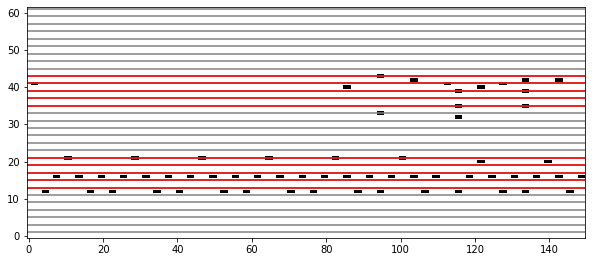

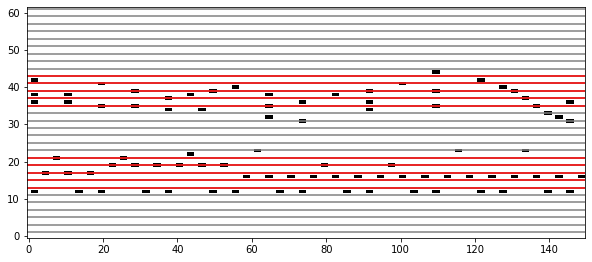

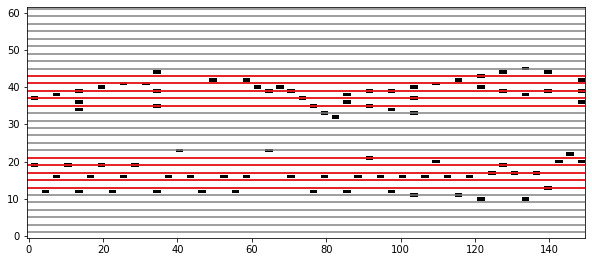

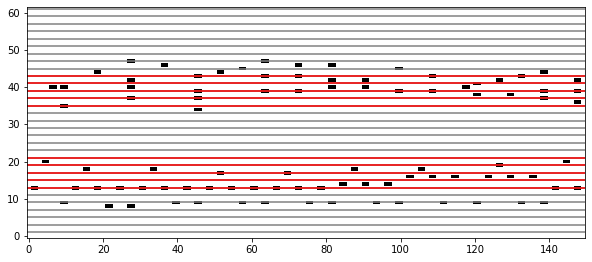

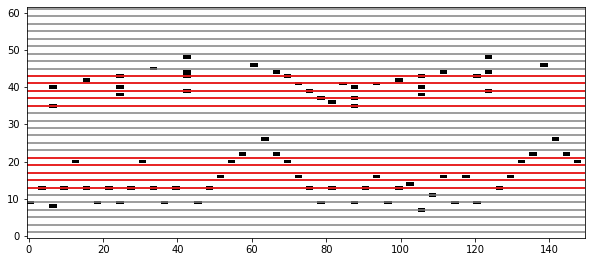

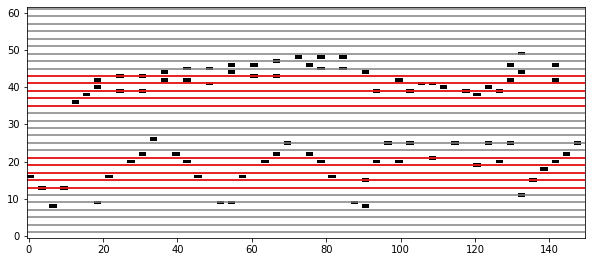

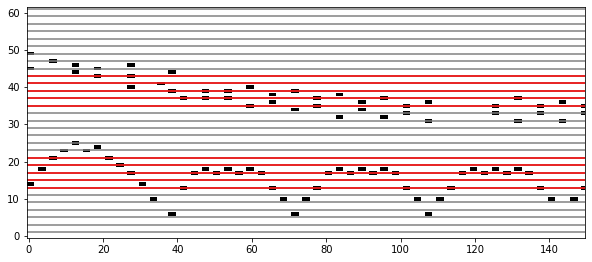

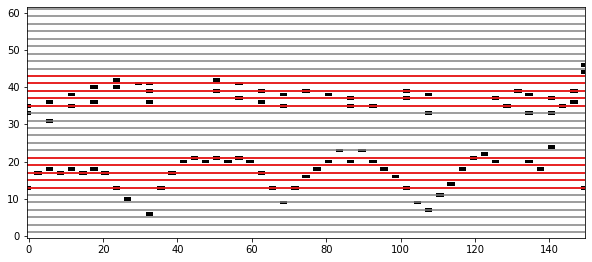

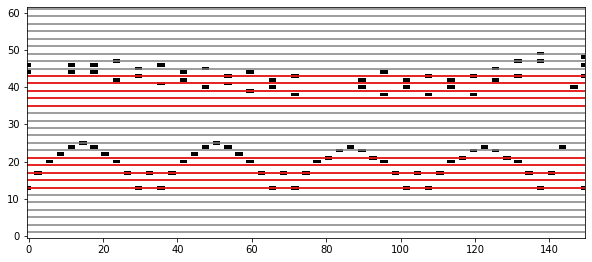

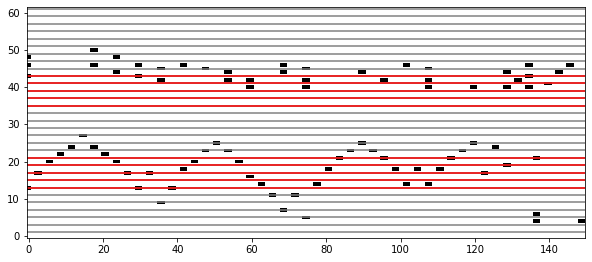

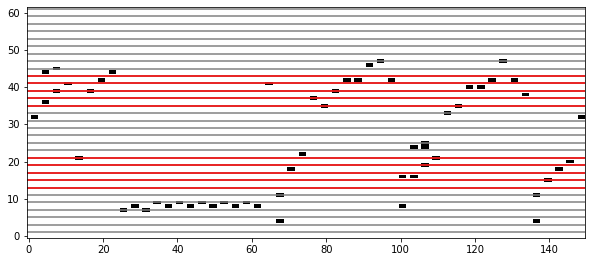

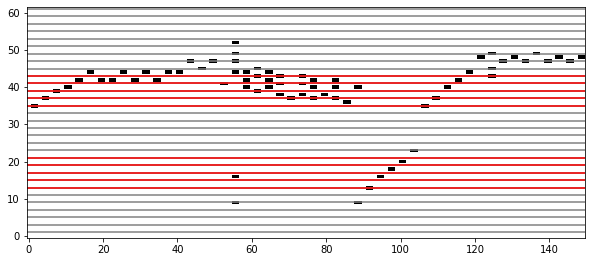

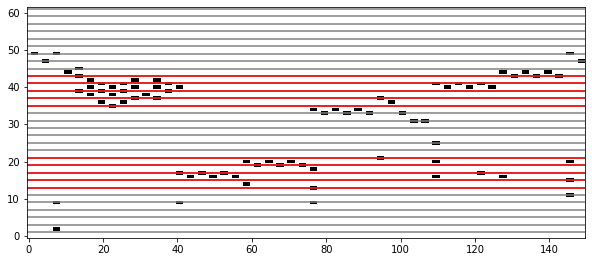

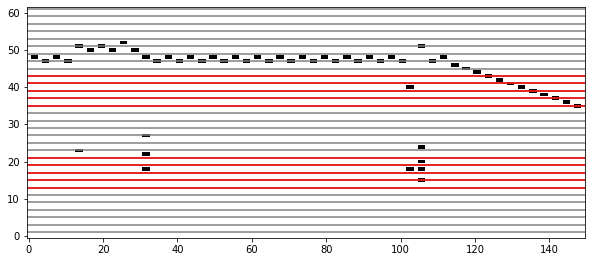

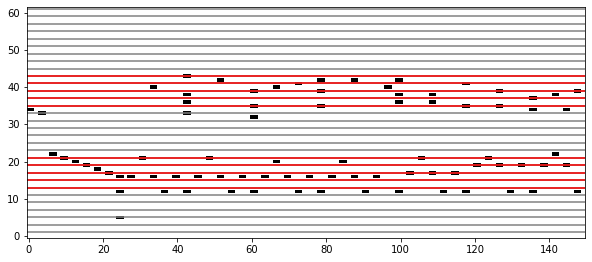

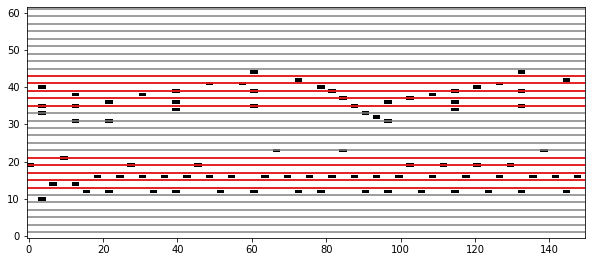

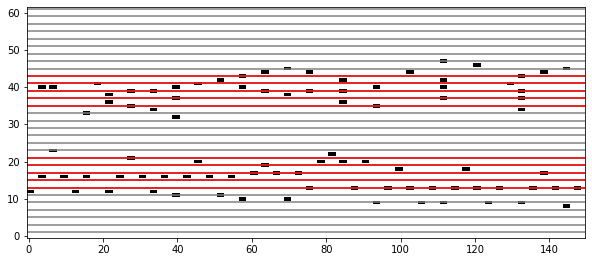

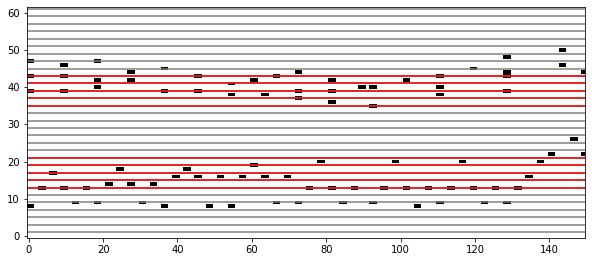

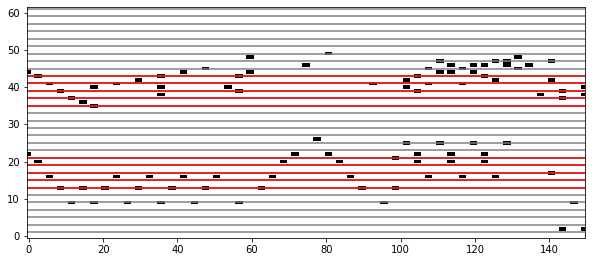

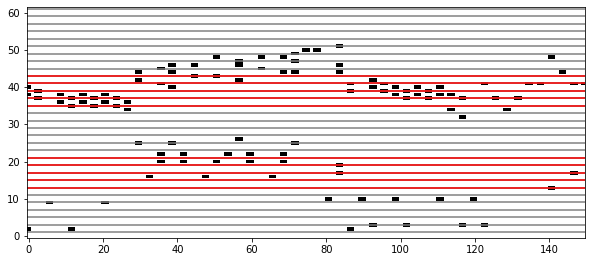

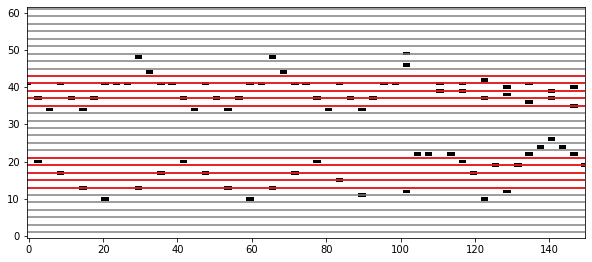

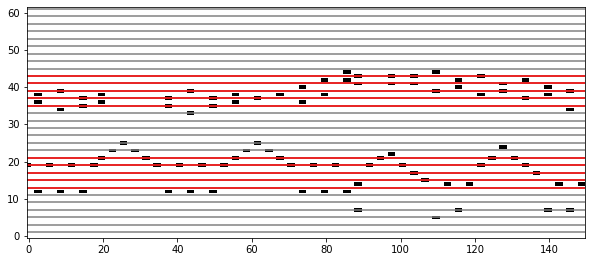

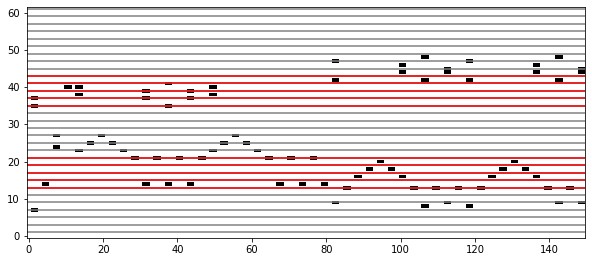

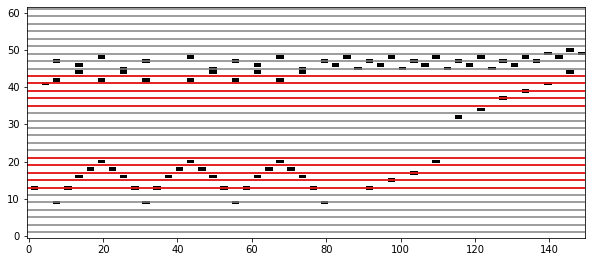

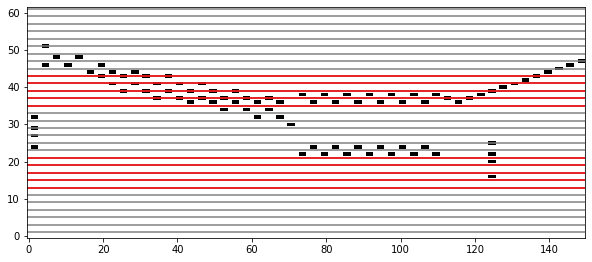

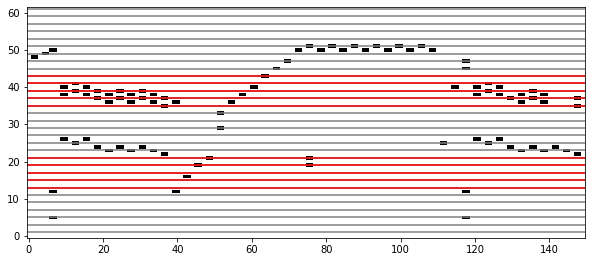

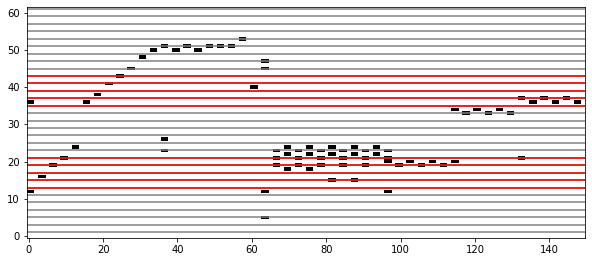

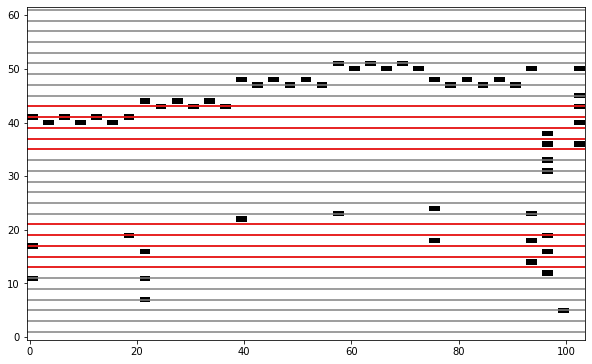

In [32]:
with open("/home/dyang/SheetMidiSearch/SheetMidiSearchRetrieval/experiments/allBootlegScores-c/scores/p1237.pkl", 'rb') as pickle_file:
    data = pickle.load(pickle_file)
    staffLinesBoth = [13,15,17,19,21,35,37,39,41,43]
    visualizeLongBootlegScore(data,staffLinesBoth)